## Conv2D

In [1]:
import autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
# Check if GPU is available
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [3]:
import sys
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sys.path.append('../src')

import tensorflow as tf
from data_processing.mtb_data_provider import MtbDataProvider
from visualization.visualize import MtbVisualizer
from models.conv1d_model import Conv1dModel
from models.conv2d_model import Conv2dModel
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
WINDOW_SIZE = 1000 # in milliseconds
KERNEL_LENGTH = 20 #in sample data points
KERNEL_HEIGHT = 2
FREQUENCY = 40 # in milliseconds
SAMPLE_SIZE = WINDOW_SIZE // FREQUENCY
print("SAMPLE_SIZE =", SAMPLE_SIZE)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

SAMPLE_SIZE = 25


### Prepare data

<img src="img/input_shape.png" alt="Drawing" style="width: 600px;"/>

#### Conv2d, multiple Sensors and multiple sessions

In [5]:
RAW_FILES = ['sachrang'] # Multiple Sessions ['neureuth', 'anothersession']

In [6]:
def load_data():
    X_result = None
    y_result = None
    for raw_file in RAW_FILES:
        X_tmp, y_tmp = MtbDataProvider.load_data('../data/raw/' + raw_file, '*?[0-9].csv', frequency=FREQUENCY)
        X_tmp = MtbDataProvider.sync_sensors(X_tmp)
        X_tmp, y_tmp = MtbDataProvider.slice_sensors(X_tmp, y_tmp, window_size=WINDOW_SIZE, frequency=FREQUENCY, step_size=.25)

        if X_result is None:
            X_result = X_tmp
            y_result = y_tmp
        else:
            X_result = np.concatenate((X_result, X_tmp))
            y_result = np.concatenate((y_result, y_tmp))

    return X_result, y_result
X, y = load_data()

reading  ../data/raw/sachrang_acc_1.csv
reading  ../data/raw/sachrang_acc_2.csv
reading  ../data/raw/sachrang_gyr_1.csv
reading  ../data/raw/sachrang_gyr_2.csv


In [7]:
# IF THERE IS NO VALIDATION SESSION (yet), split 80/20
# Do not run this multiple times in a row, because it overwrites X_train and therefore will get smaller and smaller

from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=.1, random_state=RANDOM_SEED, shuffle=True)

In [8]:
print(X_train.shape, y_train.shape)
print(X_dev.shape, y_dev.shape)

(16948, 25, 4, 3) (16948,)
(1884, 25, 4, 3) (1884,)


In [11]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=RANDOM_SEED)
X_res, y_res = sm.fit_resample(X_train, y_train)
print(X_res.shape, y_res.shape)

ValueError: Found array with dim 4. Estimator expected <= 2.

## Evaluation

### Conv2D, Multiple Sensors

In [ ]:
model_cnn2 = Conv2dModel.build_model(input_shape=X_train[0].shape, 
                                     cnn_blocks=3,
                                     dropout=0.3,
                                     kernel_size=(KERNEL_LENGTH, KERNEL_HEIGHT))

In [ ]:
model_cnn2.summary()

In [ ]:
filepath="../checkpoints/conv2d-" + str(WINDOW_SIZE) + "-" + str(KERNEL_LENGTH) + "-{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_best_only = True, monitor='val_sparse_categorical_accuracy', mode='max')
model_cnn2.fit(X_train, y_train,
              epochs=300,
              batch_size=16,
              validation_data=(X_dev, y_dev), 
              callbacks = [checkpoint])

In [ ]:
plt.plot(model_cnn2.history.history['loss'])
plt.plot(model_cnn2.history.history['val_loss'])
plt.show()

## Evaluation

* 0 = blue = easy
* 1 = red = medium
* 2 = black = hard
* 3 = white = not riding

### Predicted results

In [ ]:
y_pred_dev = model_cnn2.predict(X_dev)
y_pred_dev = np.argmax(y_pred_dev, axis=1)

In [ ]:
# This only plots the first sensor
X_dev_plot = X_dev if len(X_dev.shape) <= 3 else X_dev[:,:,0]
MtbVisualizer.plot_results(X_dev_plot, y_pred_dev, SAMPLE_SIZE)

### True results

In [ ]:
MtbVisualizer.plot_results(X_dev_plot, y_dev, SAMPLE_SIZE)

In [ ]:
MtbVisualizer.print_confusion_matrix(y_dev, y_pred_dev, labels=[0,1,2,3])

### Test on Train data

In [ ]:
y_pred = model_cnn2.predict(X)
y_pred = np.argmax(y_pred, axis=1)

### Predicted results

In [ ]:
X_plot = X[:,:,0]
MtbVisualizer.plot_results(X_plot, y_pred, SAMPLE_SIZE)

### True results

In [ ]:
X_plot = X[:,:,0]
MtbVisualizer.plot_results(X_plot, y, SAMPLE_SIZE)

In [ ]:
MtbVisualizer.print_confusion_matrix(y, y_pred, labels=[0,1,2,3])

## Explore per sensor

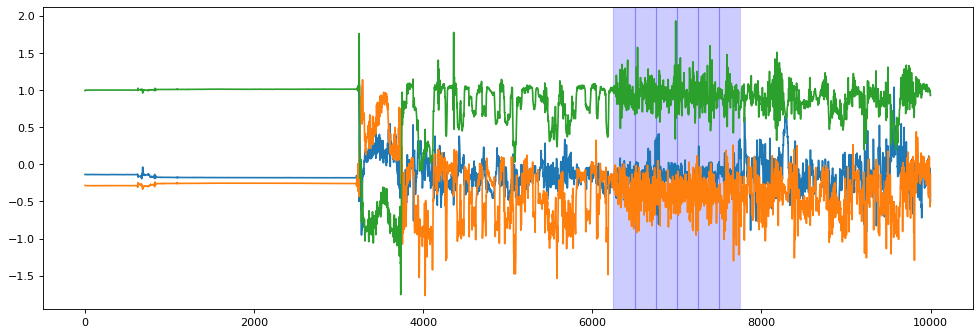

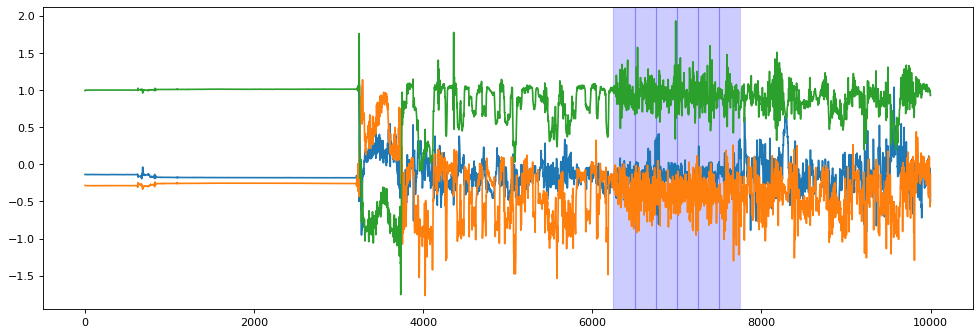

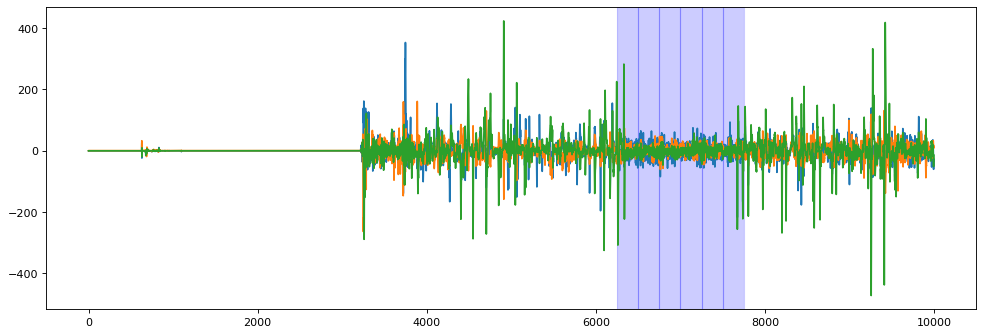

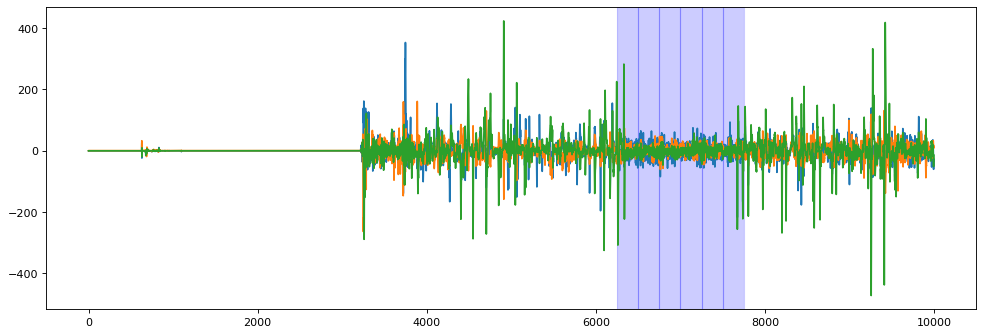

In [48]:
for i in range(0, X.shape[2]):
    X_plot = X if len(X.shape) <= 3 else X[:,:,i]
#    X_plot = X_plot[0:40]
    y_plot = y
#    y_plot = y_plot[0:40]
    MtbVisualizer.plot_results(X_plot, y_plot, SAMPLE_SIZE, plot_one_axis=0)